In [4]:
import pandas as pd
data = pd.read_csv('optimization_log2.csv')
data

,row,minn,maxx,phase,loss
0,0,0.348832,0.893278,2.889163,1.864007
1,1,0.342921,0.863502,2.922657,1.864007
2,2,0.337009,0.833727,2.956152,1.864007
3,3,0.331097,0.803951,2.989647,1.864007
4,4,0.325185,0.774175,3.023142,1.864007
...,...,...,...,...,...
135395,691,0.512246,0.809685,1.066149,34.186233
135396,692,0.540755,0.798716,1.065748,34.079568
135397,693,0.569265,0.787747,1.065348,33.987112
135398,694,0.597774,0.776778,1.064947,33.848801


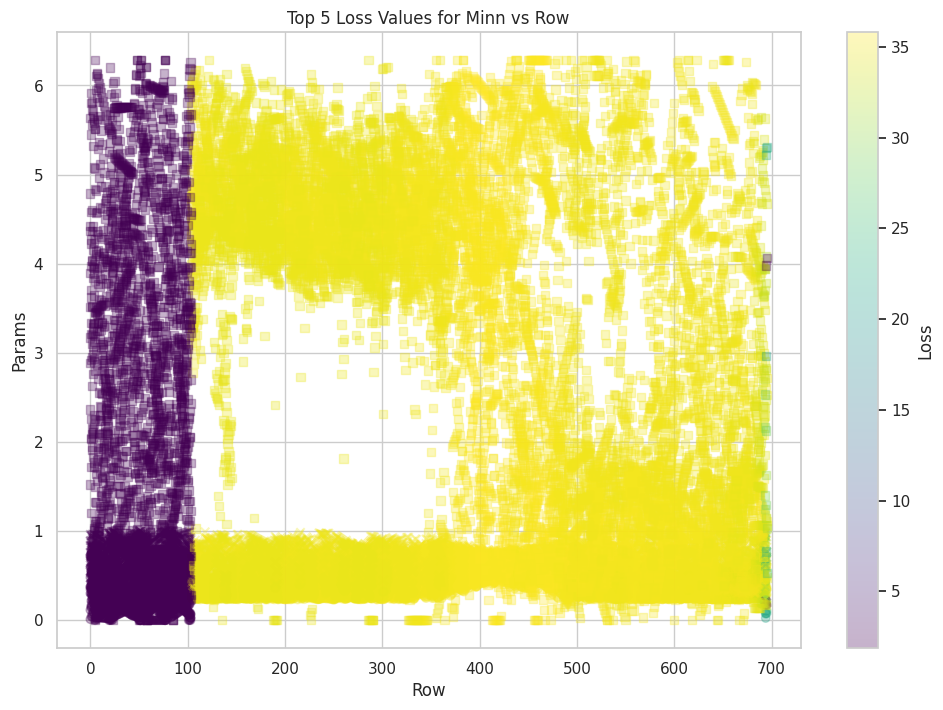

In [22]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame

# Function to get the top N rows with the highest 'loss' within each group
def top_n_per_group(df, n=5, column='loss'):
    return df.sort_values(by=column, ascending=False).groupby('row').head(n)

# Apply the function to get the top 5 loss values per row
top_loss_per_row = top_n_per_group(data, n=20)

# Filter out rows where the 'loss' is below the threshold
filtered_top_loss_per_row = top_loss_per_row[top_loss_per_row['loss'] > -1]  # don't filter


# Plotting
plt.figure(figsize=(12, 8))
sc = plt.scatter(filtered_top_loss_per_row['row'], filtered_top_loss_per_row['minn'], c=filtered_top_loss_per_row['loss'], cmap='viridis', alpha=0.3, marker='o')
sc = plt.scatter(filtered_top_loss_per_row['row'], filtered_top_loss_per_row['maxx'], c=filtered_top_loss_per_row['loss'], cmap='viridis', alpha=0.3, marker='x')
sc = plt.scatter(filtered_top_loss_per_row['row'], filtered_top_loss_per_row['phase'], c=filtered_top_loss_per_row['loss'], cmap='viridis', alpha=0.3, marker='s')
plt.colorbar(sc, label='Loss')
plt.xlabel('Row')
plt.ylabel('Params')
plt.title('Top 5 Loss Values for Minn vs Row')
plt.show()


In [23]:
import numpy as np
import tqdm

df = filtered_top_loss_per_row
df.sort_values('row', inplace=True)
df['valuea'] = 0
for current_row in tqdm.tqdm(df['row'].unique()[1:]):
    current_nodes = df[df['row'] == current_row]
    previous_nodes = df[df['row'] == current_row - 1]
    for current_index, current_node in current_nodes.iterrows():
        l1_norms = np.abs(previous_nodes[['minn', 'maxx', 'phase']].values - current_node[['minn', 'maxx', 'phase']].values).sum(axis=1)
        valid_parents = previous_nodes[l1_norms <= 1]
        if not valid_parents.empty:
            max_parent_value = valid_parents['valuea'].max()
            df.at[current_index, 'valuea'] = max_parent_value + current_node['loss']
        else:
            df.at[current_index, 'valuea'] = current_node['loss']

df['valueb'] = 0.0  # do the same but backwards
unique_rows = df['row'].unique()
for current_row in tqdm.tqdm(unique_rows[:-1][::-1]):
    current_nodes = df[df['row'] == current_row]
    next_nodes = df[df['row'] == current_row + 1]

    for current_index, current_node in current_nodes.iterrows():
        l1_norms = np.abs(next_nodes[['minn', 'maxx', 'phase']].values - current_node[['minn', 'maxx', 'phase']].values).sum(axis=1)
        valid_children = next_nodes[l1_norms <= 1]

        if not valid_children.empty:
            max_child_value = valid_children['valueb'].max()
            df.at[current_index, 'valueb'] = max_child_value + current_node['loss']
        else:
            df.at[current_index, 'valueb'] = current_node['loss']

df['value'] = df['valuea'] + df['valueb'] - df['loss']


100%|██████████| 695/695 [00:12<00:00, 56.71it/s]


        row      minn      maxx     phase       loss        valuea  \
160       0  0.115262  0.543491  1.524697   1.864007      0.000000   
320       1  0.428129  0.689001  0.738217   1.864007      1.864007   
440       2  0.041404  0.447248  5.730197   1.864007      3.728014   
302       3  0.264269  0.309055  0.918906   1.864007      5.592021   
363       4  0.350849  0.872675  5.613509   1.864007      7.456028   
...     ...       ...       ...       ...        ...           ...   
135295  691  0.303065  0.747336  1.249490  35.518660  21123.780546   
135296  692  0.313360  0.737197  1.215997  35.511348  21159.291894   
135297  693  0.323654  0.727058  1.182505  35.496194  21194.788088   
135298  694  0.333948  0.716919  1.149012  35.477430  21230.265518   
135399  695  0.626283  0.765809  1.064547  33.712939  21263.978457   

              valueb         value  
160     21232.129525  21230.265518  
320     21230.265518  21230.265518  
440     21228.401511  21230.265518  
302     212

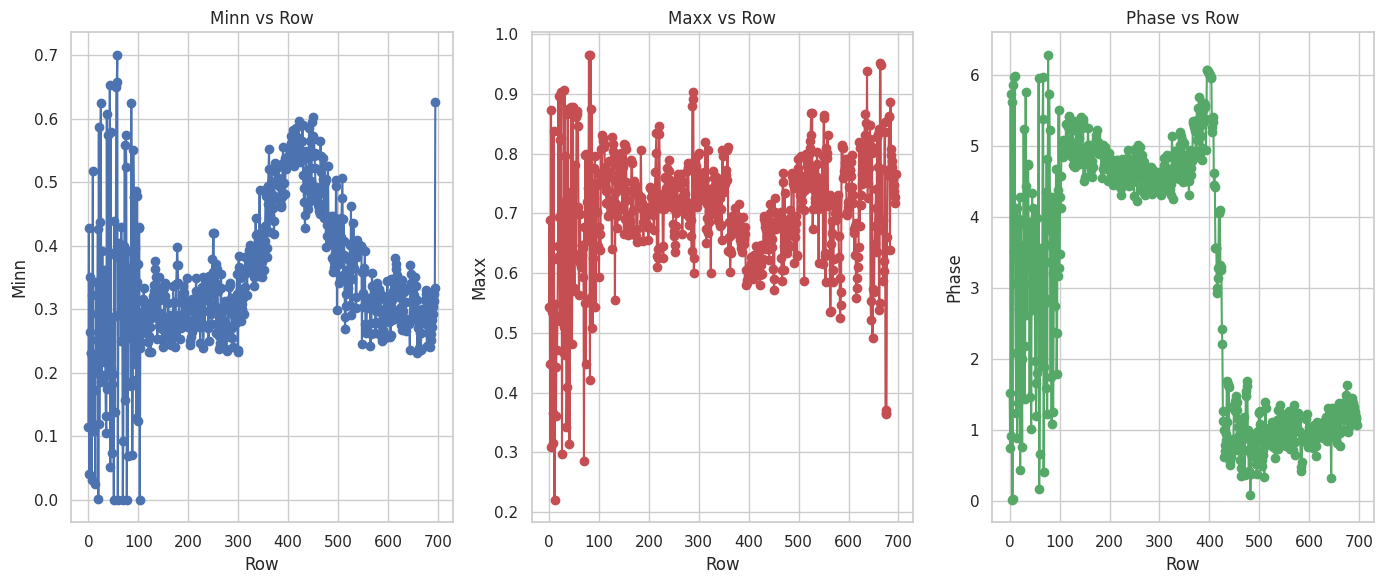

In [24]:
# Group by 'row', find the index of the max 'valuec' within each group, then select those rows
max_value_rows_per_group = df.loc[df.groupby('row')['value'].idxmax()]

# Display the rows with the maximum 'valuec' within each 'row' group
print(max_value_rows_per_group)


# Plot 'minn' vs 'row'
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)  # 1 row, 3 cols, subplot 1
plt.plot(max_value_rows_per_group['row'], max_value_rows_per_group['minn'], marker='o', linestyle='-')
plt.title('Minn vs Row')
plt.xlabel('Row')
plt.ylabel('Minn')

# Plot 'maxx' vs 'row'
plt.subplot(1, 3, 2)  # 1 row, 3 cols, subplot 2
plt.plot(max_value_rows_per_group['row'], max_value_rows_per_group['maxx'], marker='o', linestyle='-', color='r')
plt.title('Maxx vs Row')
plt.xlabel('Row')
plt.ylabel('Maxx')

# Plot 'phase' vs 'row'
plt.subplot(1, 3, 3)  # 1 row, 3 cols, subplot 3
plt.plot(max_value_rows_per_group['row'], max_value_rows_per_group['phase'], marker='o', linestyle='-', color='g')
plt.title('Phase vs Row')
plt.xlabel('Row')
plt.ylabel('Phase')

plt.tight_layout()  # Adjust the layout to make room for the titles and labels
plt.show()




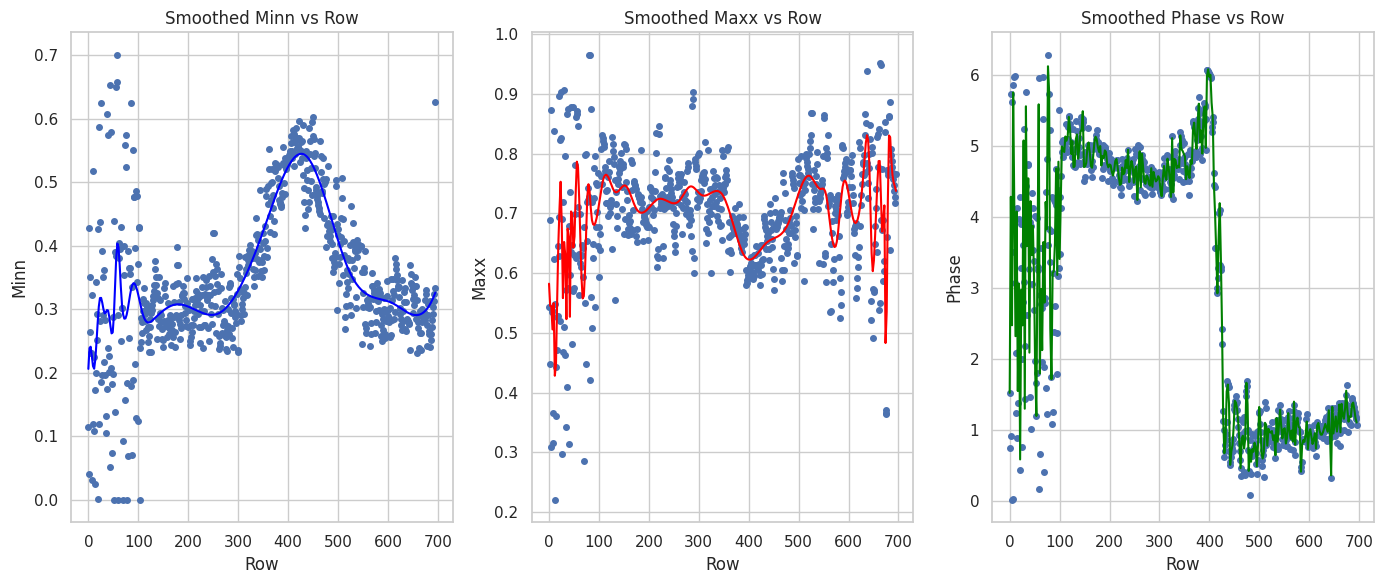

In [30]:
# smooth them out
from scipy.interpolate import UnivariateSpline
import numpy as np
import matplotlib.pyplot as plt

# Preparing the data
x = max_value_rows_per_group['row']
minn_y = max_value_rows_per_group['minn']
maxx_y = max_value_rows_per_group['maxx']
phase_y = max_value_rows_per_group['phase']

# Generating smoothed lines using UnivariateSpline
# The 's' parameter controls the amount of smoothing
s=4
minn_spline = UnivariateSpline(x, minn_y, s=s)
maxx_spline = UnivariateSpline(x, maxx_y, s=s)
phase_spline = UnivariateSpline(x, phase_y, s=s)

# Creating x values for plotting the smoothed lines
x_smooth = np.linspace(x.min(), x.max(), 300)

plt.figure(figsize=(14, 6))

# Plotting 'minn' with smoothing
plt.subplot(1, 3, 1)
plt.plot(x, minn_y, 'o', ms=4)
plt.plot(x_smooth, minn_spline(x_smooth), '-', color='blue')
plt.title('Smoothed Minn vs Row')
plt.xlabel('Row')
plt.ylabel('Minn')

# Plotting 'maxx' with smoothing
plt.subplot(1, 3, 2)
plt.plot(x, maxx_y, 'o', ms=4)
plt.plot(x_smooth, maxx_spline(x_smooth), '-', color='red')
plt.title('Smoothed Maxx vs Row')
plt.xlabel('Row')
plt.ylabel('Maxx')

# Plotting 'phase' with smoothing
plt.subplot(1, 3, 3)
plt.plot(x, phase_y, 'o', ms=4)
plt.plot(x_smooth, phase_spline(x_smooth), '-', color='green')
plt.title('Smoothed Phase vs Row')
plt.xlabel('Row')
plt.ylabel('Phase')

plt.tight_layout()
